In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy.sparse import csc
import os
import glob
import pickle
from tqdm import tqdm
import scipy

In [2]:
names = list(pd.read_csv("names.csv", header = None)[0])
Adj_mat = scipy.sparse.load_npz("adjacency_matrix.npz")
D_mat_half_inv = csc.csc_matrix(np.diag((1./np.sqrt(np.array(Adj_mat.sum(axis=0)))).flatten()))

D_V = csc.csc_matrix(np.eye(len(names)))
W_V = D_mat_half_inv@Adj_mat@D_mat_half_inv
L_V = D_V - W_V

In [3]:
output_save_dir = "output"
try:
    os.mkdir(output_save_dir)
except:
    print("Directory already created")

Directory already created


In [4]:
all_cancer_files = sorted(glob.glob("input/*.npz"))

cancer_names = [file.split("/")[1].split(".")[0].split("_")[0] for file in all_cancer_files][::2]

In [ ]:
def nmf(X_mut, X_exp):
    X_mut = scipy.sparse.load_npz("input/"+file+"_mut.npz")
    X_mut  = ((X_mut!=0)+0)
    X_exp = scipy.sparse.load_npz("input/"+file+"_exp.npz").todense()
    X_exp = X_exp[:, np.ravel(np.sum(X_mut.todense(), axis=0))>0]
    N_sample = X_mut.shape[0]

    PearsonCor = np.corrcoef(X_exp)
    sigma_bandwidth = 1.0
    W_U = np.exp(-((1.-PearsonCor)**2)/(2.*sigma_bandwidth**2))
    D_U = np.diag(np.sum(W_U,axis = 0))
    L_U = D_U - W_U

    K_num = 4
    lambda_LU = 1.0
    lambda_RU = 1.0
    lambda_LV = 1.0
    lambda_RV = 1.0

    eps_t = 10**(-5)


    U_init = np.maximum(np.random.rand(N_sample,K_num),eps_t)
    U_prev = U_init@np.diag(np.sum(U_init,axis = 0)**(-1))
    V_init = np.maximum(np.random.rand(len(names),K_num),eps_t)
    V_prev = V_init@np.diag(np.sum(U_init, axis = 0))
    delta_U = 1.
    delta_V = 1.
    cnt = 0;
    norms.append([])
    delta_u_norms.append([])
    delta_v_norms.append([])
    
    while ((delta_U > 10**(-3)) or (delta_V > 10**(-3)) and (cnt <= 500)):
        norms[idx].append(np.linalg.norm(X_mut - U_prev@V_prev.T, ord="fro"))
        cnt = cnt + 1;
        V_numer = X_mut.T@U_prev + lambda_LV*W_V@V_prev;
        V_denum = V_prev@(U_prev.T@U_prev) + lambda_LV*D_V@V_prev + lambda_RV*np.ones((len(names),len(names)))@V_prev;
        V_new = V_prev*V_numer/(V_denum + eps_t);
        U_numer = X_mut@V_new + lambda_LU*W_U@U_prev;
        U_denum = U_prev@(V_new.T@V_new) + lambda_LU*D_U@U_prev + lambda_RU*U_prev;
        U_new = U_prev*U_numer/(U_denum + eps_t);
        NormFactor = np.sum(U_new,axis = 0);
        U_new = U_new@np.diag(NormFactor**(-1));
        V_new = V_new@np.diag(NormFactor);

        delta_U = np.linalg.norm(U_prev - U_new,'fro')**2/(np.linalg.norm(U_prev,'fro')**2);
        delta_V = np.linalg.norm(V_prev - V_new,'fro')**2/(np.linalg.norm(V_prev,'fro')**2);
        
        delta_u_norms[idx].append(delta_U)
        delta_v_norms[idx].append(delta_V)
        U_prev = U_new;
        V_prev = V_new;
    top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(V_new, axis = 1)[:, -1]))[:200]])
    res = {"top_genes": top_genes, "U_new":U_new, "V_new":V_new}
    with open(output_save_dir+"/"+file+".pk", 'wb') as f:
        pickle.dump(res, f)

In [5]:
norms = []
delta_u_norms = []
delta_v_norms = []
for idx, file in enumerate(cancer_names):
    print("Run "+ file)
    X_mut = scipy.sparse.load_npz("input/"+file+"_mut.npz")
    X_mut  = ((X_mut!=0)+0)
    X_exp = scipy.sparse.load_npz("input/"+file+"_exp.npz").todense()
    X_exp = X_exp[:, np.ravel(np.sum(X_mut.todense(), axis=0))>0]
    N_sample = X_mut.shape[0]

    PearsonCor = np.corrcoef(X_exp)
    sigma_bandwidth = 1.0
    W_U = np.exp(-((1.-PearsonCor)**2)/(2.*sigma_bandwidth**2))
    D_U = np.diag(np.sum(W_U,axis = 0))
    L_U = D_U - W_U

    K_num = 4
    lambda_LU = 1.0
    lambda_RU = 1.0
    lambda_LV = 1.0
    lambda_RV = 1.0

    eps_t = 10**(-5)


    U_init = np.maximum(np.random.rand(N_sample,K_num),eps_t)
    U_prev = U_init@np.diag(np.sum(U_init,axis = 0)**(-1))
    V_init = np.maximum(np.random.rand(len(names),K_num),eps_t)
    V_prev = V_init@np.diag(np.sum(U_init, axis = 0))
    delta_U = 1.
    delta_V = 1.
    cnt = 0;
    norms.append([])
    delta_u_norms.append([])
    delta_v_norms.append([])
    
    while ((delta_U > 10**(-3)) or (delta_V > 10**(-3)) and (cnt <= 500)):
        norms[idx].append(np.linalg.norm(X_mut - U_prev@V_prev.T, ord="fro"))
        cnt = cnt + 1;
        V_numer = X_mut.T@U_prev + lambda_LV*W_V@V_prev;
        V_denum = V_prev@(U_prev.T@U_prev) + lambda_LV*D_V@V_prev + lambda_RV*np.ones((len(names),len(names)))@V_prev;
        V_new = V_prev*V_numer/(V_denum + eps_t);
        U_numer = X_mut@V_new + lambda_LU*W_U@U_prev;
        U_denum = U_prev@(V_new.T@V_new) + lambda_LU*D_U@U_prev + lambda_RU*U_prev;
        U_new = U_prev*U_numer/(U_denum + eps_t);
        NormFactor = np.sum(U_new,axis = 0);
        U_new = U_new@np.diag(NormFactor**(-1));
        V_new = V_new@np.diag(NormFactor);

        delta_U = np.linalg.norm(U_prev - U_new,'fro')**2/(np.linalg.norm(U_prev,'fro')**2);
        delta_V = np.linalg.norm(V_prev - V_new,'fro')**2/(np.linalg.norm(V_prev,'fro')**2);
        
        delta_u_norms[idx].append(delta_U)
        delta_v_norms[idx].append(delta_V)
        U_prev = U_new;
        V_prev = V_new;
    top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(V_new, axis = 1)[:, -1]))[:200]])
    res = {"top_genes": top_genes, "U_new":U_new, "V_new":V_new}
    with open(output_save_dir+"/"+file+".pk", 'wb') as f:
        pickle.dump(res, f)
    

Run brca
Run coadread
Run gbm


In [7]:
output_python_genes = glob.glob("output/*.pk")
compare_results = {}
for idx in range(len(output_python_genes)):
    name_of_cancer = output_python_genes[idx].split("/")[1].split(".")[0]
    with open(output_python_genes[idx], 'rb') as f:
        python_data = pickle.load(f)
    compare_results[name_of_cancer] = python_data["top_genes"]

In [6]:
from sklearn.decomposition import NMF

In [31]:
sklearn_model_regularized = {}
for idx, file in enumerate(cancer_names):
    X_mut = scipy.sparse.load_npz("input/"+file+"_mut.npz")
    X_mut  = ((X_mut!=0)+0)
    model = NMF(n_components=4, alpha=1.5,l1_ratio=0.66666666, random_state= 42)
    W = model.fit_transform(X_mut)
    H = model.components_
    top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(H.T, axis = 1)[:, -1]))[:10]])
    sklearn_model_regularized[cancer_names[idx]] = top_genes

In [32]:
sklearn_model_regularized

{'brca': ['PCDHA1',
  'PCDHA2',
  'PCDHA3',
  'PCDHA4',
  'PCDHA5',
  'TTN',
  'PCDHA6',
  'PCDHA7',
  'PCDHA8',
  'PCDHA9'],
 'coadread': ['TTN',
  'APC',
  'SYNE1',
  'FAT4',
  'LRP2',
  'LRP1B',
  'DMD',
  'USH2A',
  'RELN',
  'NEB'],
 'gbm': ['PTEN',
  'TP53',
  'RB1',
  'NF1',
  'EGFR',
  'DOCK1',
  'ASPM',
  'KLF6',
  'ATR',
  'TNFRSF11B']}

In [36]:
sklearn_model_non_regularized = {}
for idx, file in enumerate(cancer_names):
    X_mut = scipy.sparse.load_npz("input/"+file+"_mut.npz")
    X_mut  = ((X_mut!=0)+0)
    model = NMF(n_components=4, alpha=0., random_state= 42)
    W = model.fit_transform(X_mut)
    H = model.components_
    top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(H.T, axis = 1)[:, -1]))[:10]])
    sklearn_model_non_regularized[cancer_names[idx]] = top_genes

In [37]:
sklearn_model_non_regularized

{'brca': ['PCDHA1',
  'PCDHA2',
  'PCDHA3',
  'PCDHA4',
  'TTN',
  'PCDHA5',
  'PCDHA6',
  'PCDHA7',
  'PIK3CA',
  'PCDHA8'],
 'coadread': ['APC',
  'TTN',
  'SYNE1',
  'LRP1B',
  'DMD',
  'FAT4',
  'LRP2',
  'ABCA12',
  'RELN',
  'DNAH5'],
 'gbm': ['PTEN',
  'TP53',
  'RB1',
  'EGFR',
  'NF1',
  'DST',
  'PIK3R1',
  'COL1A1',
  'COL3A1',
  'MSH6']}

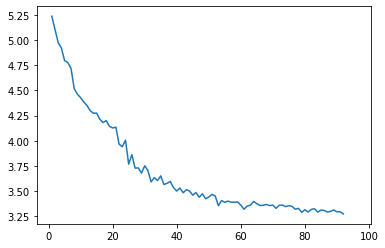

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(1,1000)), res)

In [10]:
from sklearn.decomposition import NMF

In [ ]:
NMF()

In [65]:
rand_matr= np.random.rand(10,10)
res = []
for k in range(1,10):
    nmf = NMF(n_components=k,l1_ratio= 1.0, alpha=0.,random_state= 0,init="random")
    W = nmf.fit_transform(rand_matr)
    H = nmf.components_
    #u,v,cnt = nmf_no_exp(rand_matr,k)
    res.append(np.linalg.norm(rand_matr - W@H))

In [66]:
res_nmf = res

In [67]:
res_svd = []
u, s, v = np.linalg.svd(rand_matr, full_matrices=True)
sigma = np.zeros((u.shape[0], v.shape[0]))
np.fill_diagonal(sigma, s)


In [68]:
for k in range(1,10):
    res_svd.append(np.linalg.norm(rand_matr - u[:, :k]@sigma[:k, :k]@v[:k, :]))

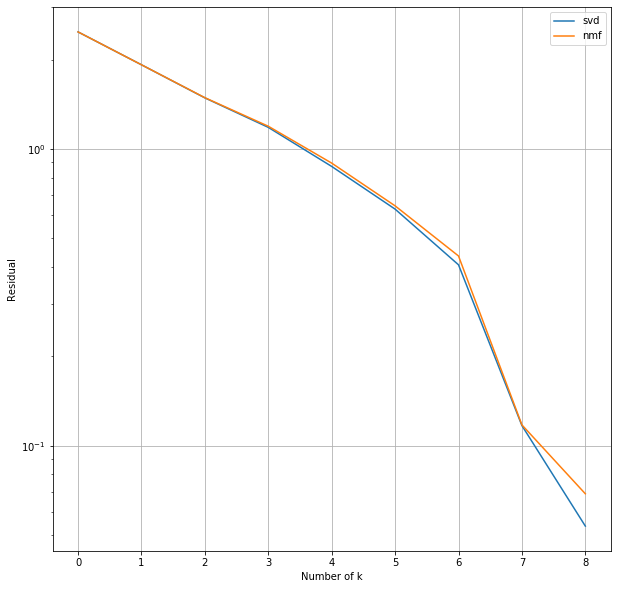

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(res_svd, label = 'svd')
plt.semilogy(res_nmf[:10], label = 'nmf')
plt.legend()
plt.xlabel("Number of k")
plt.ylabel("Residual")
plt.grid()

In [85]:
U, V, cnt = nmf(brca_mut, brca_exp, 4)

4


In [88]:
U

array([[0.00122953, 0.00123116, 0.00122958, 0.00122966],
       [0.00114865, 0.00112538, 0.0011255 , 0.00110677],
       [0.00096851, 0.00096067, 0.00095405, 0.0009503 ],
       ...,
       [0.00093698, 0.00093597, 0.00093563, 0.00093575],
       [0.0009369 , 0.00093584, 0.00093551, 0.0009356 ],
       [0.00102143, 0.00104537, 0.00104331, 0.00106226]])

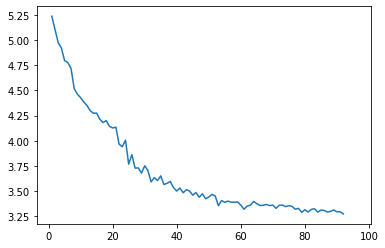

In [40]:

plt.plot(list(range(1,1000)), res)

In [42]:
v

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
brca_

1
101
201
301
401
501
601
701
801
901


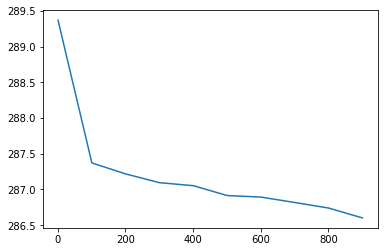

In [47]:
res = []
for k in range(1,1000,100):
    u,v,cnt = nmf_no_exp(brca_mut,k)
    res.append(np.linalg.norm(brca_mut - u@v.T))
plt.plot(list(range(1,1000,100)), res)

In [ ]:
u,v,cnt = nmf_no_exp(brca_mut,3000)
res.append(np.linalg.norm(brca_mut - u@v.T))

3000


In [122]:
counts = []
svd_norms = []
nmf_norms = []
u, s, v = np.linalg.svd(brca_mut, full_matrices=True)
sigma = np.zeros((u.shape[0], v.shape[0]))
np.fill_diagonal(sigma, s)

for i in tqdm(range(1,970, 20)):
    u_brca, v_brca, cnt = nmf(brca_mut, brca_exp, i)
    nmf_norms.append(np.linalg.norm(brca_mut - u_brca@(v_brca.T)))
    svd_norms.append(np.linalg.norm(brca_mut - u[:, :i]@sigma[:i, :i]@v[:i, :]))
    counts.append(cnt)
    






  0%|          | 0/49 [00:00<?, ?it/s]




  2%|▏         | 1/49 [00:05<04:09,  5.20s/it]




  4%|▍         | 2/49 [00:11<04:14,  5.41s/it]




  6%|▌         | 3/49 [00:16<04:10,  5.45s/it]




  8%|▊         | 4/49 [00:22<04:09,  5.55s/it]




 10%|█         | 5/49 [00:28<04:05,  5.59s/it]




 12%|█▏        | 6/49 [00:34<04:14,  5.91s/it]




 14%|█▍        | 7/49 [00:41<04:23,  6.27s/it]




 16%|█▋        | 8/49 [00:48<04:18,  6.30s/it]




 18%|█▊        | 9/49 [00:54<04:15,  6.38s/it]




 20%|██        | 10/49 [01:01<04:13,  6.51s/it]




 22%|██▏       | 11/49 [01:08<04:16,  6.74s/it]




 24%|██▍       | 12/49 [01:16<04:19,  7.02s/it]




 27%|██▋       | 13/49 [01:24<04:19,  7.22s/it]




 29%|██▊       | 14/49 [01:32<04:19,  7.40s/it]




 31%|███       | 15/49 [01:39<04:11,  7.39s/it]




 33%|███▎      | 16/49 [01:49<04:27,  8.10s/it]




 35%|███▍      | 17/49 [01:57<04:23,  8.24s/it]




 37%|███▋      | 18/49 [02:07<04:26,  8.58s/it]




 39%|███▉      | 19/49 [0

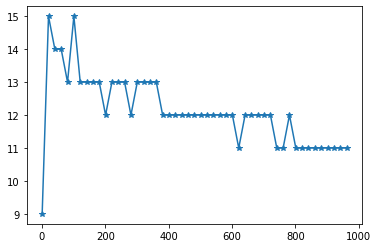

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(1,970,20)), counts, '-*')

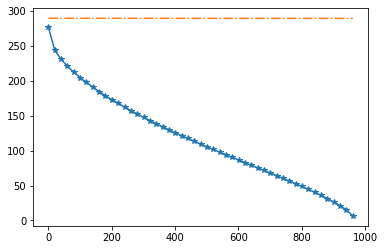

In [126]:
plt.plot(list(range(1,970,20)), svd_norms, '-*')
plt.plot(list(range(1,970,20)), nmf_norms, '-.')


In [137]:
rand_matr = np.random.rand(10,12199)

In [138]:
rand_matr_expr = np.random.rand(10,12199)

In [139]:
counts_rand_matr = []
svd_norms_rand_matr = []
nmf_norms_rand_matr = []
u, s, v = np.linalg.svd(rand_matr, full_matrices=True)
sigma = np.zeros((u.shape[0], v.shape[0]))
np.fill_diagonal(sigma, s)

for i in tqdm(range(1,10)):
    u_nmf, v_nmf, cnt = nmf(rand_matr, rand_matr_expr, i)
    nmf_norms.append(np.linalg.norm(rand_matr - u_nmf@(v_nmf.T)))
    svd_norms.append(np.linalg.norm(rand_matr - u[:, :i]@sigma[:i, :i]@v[:i, :]))
    counts.append(cnt)
    






  0%|          | 0/9 [00:00<?, ?it/s]

1


ValueError: operands could not be broadcast together with shapes (12199,1) (12129,1) 

In [53]:
import sklearn.de

In [ ]:
NMF()

In [128]:
nmf(brca_mut, brca_exp, 10)

10


(array([[0.00123174, 0.00122648, 0.00122742, ..., 0.00122618, 0.00122774,
         0.00123008],
        [0.00111807, 0.00110823, 0.00110713, ..., 0.00110236, 0.00109655,
         0.00111061],
        [0.00096314, 0.0009393 , 0.00094245, ..., 0.00093749, 0.00094345,
         0.00095356],
        ...,
        [0.00093635, 0.00093532, 0.00093545, ..., 0.00093539, 0.00093584,
         0.00093586],
        [0.0009362 , 0.00093518, 0.0009353 , ..., 0.00093524, 0.00093568,
         0.00093571],
        [0.00105365, 0.00105714, 0.00105932, ..., 0.00106278, 0.00107064,
         0.00105895]]),
 array([[9.74390294e-19, 2.47056527e-19, 2.61568277e-18, ...,
         4.03994381e-19, 1.40660843e-18, 4.87876549e-20],
        [7.62133859e-18, 4.50654619e-18, 4.62416127e-18, ...,
         4.31303697e-18, 1.16406851e-17, 2.57201267e-18],
        [2.46996973e-14, 1.37825316e-14, 1.83308242e-16, ...,
         8.18059426e-15, 6.11002348e-15, 1.23369222e-14],
        ...,
        [2.22899135e-17, 1.97964736e

In [90]:
model = NMF(n_components=4,alpha = 1.0, l1_ratio=1.0,init="random")

In [92]:
W = model.fit_transform(brca_mut)

In [93]:
H = model.components_

In [95]:
np.linalg.norm(brca_mut-W@H)/np.linalg.norm(brca_mut)

0.9262106641760143

In [ ]:
np.linalg.norm(brca_mut)

In [53]:
np.linalg.norm(brca_mut - U_brca@(V_brca.T))

289.75210440372916

In [105]:
model = NMF(n_components=4,init="random")

In [106]:
W = model.fit_transform(brca_mut)

In [107]:
H = model.components_

In [108]:
np.linalg.norm(brca_mut-W@H)

267.9550957076446

In [110]:
top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(H.T, axis = 1)[:, -1]))[:10]])

In [ ]:
np.linalg.norm(brca_mut)

In [53]:
np.linalg.norm(brca_mut - U_brca@(V_brca.T))

289.75210440372916

In [54]:
u, s, v = np.linalg.svd(brca_mut, full_matrices=True)

In [64]:
u.shape

(970, 970)

In [89]:
sigma = np.zeros((u.shape[0], v.shape[0]))
np.fill_diagonal(sigma, s)

In [81]:
u.shape

(970, 970)

In [88]:
np.fill_diagonal(np.zeros((u.shape[0], v.shape[0])), s)

In [104]:
np.linalg.norm(brca_mut - u[:, :4]@np.diag(s[:4])@v[:4, :])

267.6592815889059

In [97]:
u[:, :4].shape

(970, 4)

In [103]:
v[:4, :].shape

(4, 12129)

In [105]:
X_mut

<503x12129 sparse matrix of type '<class 'numpy.bool_'>'
	with 21161 stored elements in Compressed Sparse Column format>

In [95]:
u[:, :4]@sigma

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 970 is different from 4)

In [74]:
temp = np.random.rand(4,4)
u_temp, s_temp, v_temp = np.linalg.svd(temp)

In [63]:
np.diag(s).shape

(970, 970)

In [61]:
v.shape

(12129, 12129)

In [42]:
top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(V_brca, axis = 1)[:, -1]))[:200]])
res = {"top_genes": top_genes, "U_new":U_new, "V_new":V_new}
    

In [44]:
top_genes[:10]

['PIK3CA',
 'TP53',
 'TTN',
 'MUC16',
 'PCDHA4',
 'PCDHA1',
 'PCDHA2',
 'PCDHA3',
 'PCDHA6',
 'CDH1']

In [49]:
top_genes[:10]

['TP53',
 'PIK3CA',
 'TTN',
 'MUC16',
 'GATA3',
 'MAP3K1',
 'CDH1',
 'RYR2',
 'USH2A',
 'OBSCN']

In [46]:
all_cancer_files = [all_cancer_files[2]]


In [47]:
norms = []
delta_u_norms = []
delta_v_norms = []
for idx, file in enumerate(all_cancer_files):
    print("Run "+ file)
    d = loadmat(file)

    X_mut  = ((d["X_SNV_Net"]!=0)+0)
    X_exp = d["X_EXP_Net"][:, np.ravel(np.sum(X_mut.todense(), axis=0))>0]
    N_sample = X_mut.shape[0]

    PearsonCor = np.corrcoef(X_exp)
    sigma_bandwidth = 1.0
    W_U = np.exp(-((1.-PearsonCor)**2)/(2.*sigma_bandwidth**2))
    D_U = np.diag(np.sum(W_U,axis = 0))
    L_U = D_U - W_U

    K_num = 4
    lambda_LU = 1.0
    lambda_RU = 1.0
    lambda_LV = 1.0
    lambda_RV = 1.0

    # --- RS-CRNMF --- %
    #print('run RS-CRNMF ...')
    eps_t = 10**(-5)


    U_init = np.maximum(np.random.rand(N_sample,K_num),eps_t)
    U_prev = U_init@np.diag(np.sum(U_init,axis = 0)**(-1));
    V_init = np.maximum(np.random.rand(len(names),K_num),eps_t);
    V_prev = V_init@np.diag(np.sum(U_init, axis = 0));
    delta_U = 1.;
    delta_V = 1.;
    cnt = 0;
    norms.append([])
    delta_u_norms.append([])
    delta_v_norms.append([])
    
    while ((delta_U > 10**(-3)) or (delta_V > 10**(-3)) and (cnt <= 500)):
        norms[idx].append(np.linalg.norm(X_mut - U_prev@V_prev.T, ord="fro"))
        cnt = cnt + 1;
        V_numer = X_mut.T@U_prev + lambda_LV*W_V@V_prev;
        V_denum = V_prev@(U_prev.T@U_prev) + lambda_LV*D_V@V_prev + lambda_RV*np.ones((len(names),len(names)))@V_prev;
        V_new = V_prev*V_numer/(V_denum + eps_t);
        #print("V_new ", V_new.shape)
        U_numer = X_mut@V_new + lambda_LU*W_U@U_prev;
        U_denum = U_prev@(V_new.T@V_new) + lambda_LU*D_U@U_prev + lambda_RU*U_prev;
        U_new = U_prev*U_numer/(U_denum + eps_t);
        #print("U_new "U_new.shape)
        NormFactor = np.sum(U_new,axis = 0);
        #print(NormFactor.shape)
        U_new = U_new@np.diag(NormFactor**(-1));
        V_new = V_new@np.diag(NormFactor);

        delta_U = np.linalg.norm(U_prev - U_new,'fro')**2/(np.linalg.norm(U_prev,'fro')**2);
        delta_V = np.linalg.norm(V_prev - V_new,'fro')**2/(np.linalg.norm(V_prev,'fro')**2);
        
        delta_u_norms[idx].append(delta_U)
        delta_v_norms[idx].append(delta_V)
        U_prev = U_new;
        V_prev = V_new;
    top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(V_new, axis = 1)[:, -1]))[:200]])
    res = {"top_genes": top_genes, "U_new":U_new, "V_new":V_new}
    with open(output_save_dir+"/"+cancer_names[idx]+".pk", 'wb') as f:
        pickle.dump(res, f)
    

Run input_cancer_data/brca_tcga_pub.mat


In [329]:
X_mut = X_mut.T

In [331]:
U,V = nmf_t(X_mut)

(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)
(12129, 4)
(503, 4)


In [ ]:
matrices = []
for idx, file in enumerate(all_cancer_files):
    X_mut  = ((d["X_EXP_Net"]))
    matrices.append(X_mut)
y = []
for idx in range(len(matrices)):
    y += [idx]*len(matrices[idx])
y = np.array(y)
X = np.vstack(matrices)
import xgboost as xgb

In [288]:
norms = []
delta_u_norms = []
delta_v_norms = []
#for idx, file in enumerate(all_cancer_files):
    

Run input_cancer_data/gbm_tcga_pub.mat
Run input_cancer_data/coadread_tcga_pub.mat
Run input_cancer_data/brca_tcga_pub.mat


In [299]:
U_prev.shape

(12129, 4)

In [300]:
V_prev.shape

(503, 4)

In [ ]:
np.argmax(V_prev.)

In [ ]:
def nmf_t(X_mut):
    #print("Run "+ file)
    #d = loadmat(file)

    #X_mut  = ((d["X_SNV_Net"]!=0)+0)
    #X_exp = d["X_EXP_Net"][:, np.ravel(np.sum(X_mut.todense(), axis=0))>0]
    N_sample = X_mut.shape[0]
    X_mut = X_mut.T
    #X_exp = X_exp.T
    

    PearsonCor = np.corrcoef(X_exp)
    sigma_bandwidth = 1.0
    #W_U = np.exp(-((1.-PearsonCor)**2)/(2.*sigma_bandwidth**2))
    #D_U = np.diag(np.sum(W_U,axis = 0))
    #L_U = D_U - W_U

    K_num = 4
    lambda_LU = 1.0
    lambda_RU = 1.0
    lambda_LV = 1.0
    lambda_RV = 1.0

    # --- RS-CRNMF --- %
    #print('run RS-CRNMF ...')
    eps_t = 10**(-5)


    U_init = np.maximum(np.random.rand(len(names),K_num),eps_t)
    print(U_init.shape)
    U_prev = U_init@np.diag(np.sum(U_init,axis = 0)**(-1));
    V_init = np.maximum(np.random.rand(N_sample,K_num),eps_t);
    print(V_init.shape)
    V_prev = V_init@np.diag(np.sum(U_init, axis = 0));
    delta_U = 1.;
    delta_V = 1.;
    cnt = 0;
    norms.append([])
    delta_u_norms.append([])
    delta_v_norms.append([])
    
    while ((delta_U > 10**(-3)) or (delta_V > 10**(-3)) and (cnt <= 500)):
        print(U_prev.shape)
        print(V_prev.shape)
        norms[idx].append(np.linalg.norm(X_mut - U_prev@V_prev.T, ord="fro"))
        cnt = cnt + 1;
        V_numer = X_mut.T@U_prev# + lambda_LV*W_U@V_prev;
        #print(D_U.shape)
        #print(V_prev.shape)
        V_denum = V_prev@(U_prev.T@U_prev)+lambda_RV*np.ones((N_sample,N_sample))@V_prev#; + lambda_LV*D_U@V_prev + 
        V_new = V_prev*V_numer/(V_denum + eps_t);
        #print("V_new ", V_new.shape)
        U_numer = X_mut@V_new + lambda_LU*W_V@U_prev;
        U_denum = U_prev@(V_new.T@V_new) + lambda_LU*D_V@U_prev + lambda_RU*U_prev;
        U_new = U_prev*U_numer/(U_denum + eps_t);
        #print("U_new "U_new.shape)
        NormFactor = np.sum(U_new,axis = 0);
        #print(NormFactor.shape)
        U_new = U_new@np.diag(NormFactor**(-1));
        V_new = V_new@np.diag(NormFactor);

        delta_U = np.linalg.norm(U_prev - U_new,'fro')**2/(np.linalg.norm(U_prev,'fro')**2);
        delta_V = np.linalg.norm(V_prev - V_new,'fro')**2/(np.linalg.norm(V_prev,'fro')**2);
        
        delta_u_norms[idx].append(delta_U)
        delta_v_norms[idx].append(delta_V)
        U_prev = U_new;
        V_prev = V_new;
    top_genes = list(pd.Series(names)[np.flip(np.argsort(np.sort(V_new, axis = 1)[:, -1]))[:200]])
    #res = {"top_genes": top_genes, "U_new":U_new, "V_new":V_new}
    #with open(output_save_dir+"/"+cancer_names[idx]+".pk", 'wb') as f:
    #    pickle.dump(res, f)
    return U_prev, V_prev

In [7]:
output_matlab_genes = glob.glob("output/*.mat")
output_python_genes = glob.glob("output/*.pk")
compare_results = {}
for idx in range(len(output_python_genes)):
    name_of_cancer = output_python_genes[idx].split("/")[1].split(".")[0]
    matlab_data = loadmat(output_matlab_genes[idx])
    with open(output_python_genes[idx], 'rb') as f:
        python_data = pickle.load(f)
    compare_results[name_of_cancer] = [matlab_data['Candidates_list'], python_data["top_genes"]]

IndexError: list index out of range

In [8]:
pd.DataFrame.from_dict(compare_results)

""


In [124]:
X_mut  = ((d["X_SNV_Net"]!=0)+0)
X_exp = d["X_EXP_Net"][:, np.ravel(np.sum(X_mut.todense(), axis=0))>0]

In [126]:
X_mut.shape

(503, 12129)

In [183]:
matrices = []
for idx, file in enumerate(all_cancer_files):
    X_mut  = ((d["X_EXP_Net"]))
    matrices.append(X_mut)
y = []
for idx in range(len(matrices)):
    y += [idx]*len(matrices[idx])
y = np.array(y)
X = np.vstack(matrices)
import xgboost as xgb

In [184]:
y.shape

(1509,)

In [185]:
X.shape

(1509, 12129)

In [186]:
X

array([[ 0.94933333,  0.        ,  0.242     , ..., -0.38016667,
        -0.13533333,  0.369     ],
       [ 0.27983333,  0.        ,  1.0385    , ...,  0.07616667,
        -0.36633333,  0.0345    ],
       [ 0.74866667,  0.        ,  1.1605    , ...,  0.89633333,
         0.215     , -0.0495    ],
       ...,
       [ 0.69683333,  0.        ,  1.042     , ..., -0.1995    ,
         1.08466667, -0.4065    ],
       [-0.28066667,  0.        ,  0.7175    , ...,  0.37      ,
        -0.1615    , -0.5665    ],
       [-0.3155    ,  0.        ,  0.6455    , ..., -0.13016667,
         0.35083333,  0.1445    ]])

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, shuffle = True, random_state = 42)
clf = xgb.XGBClassifier(max_depth=4,n_estimators=100,njobs = -1,)


In [15]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              njobs=-1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [16]:
y_pred = clf.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_test, y_pred)

0.039735099337748346

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
logreg = LogisticRegression()

In [21]:
logreg.fit(X_train, y_train)

/home/mikhailfrolov/yes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikhailfrolov/yes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_pred = logreg.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.016556291390728478

In [27]:
len(names)

12129

In [30]:
output_python_genes = glob.glob("output/*.pk")
vocab = {}
for idx in range(len(output_python_genes)):
    name_of_cancer = output_python_genes[idx].split("/")[1].split(".")[0]
    with open(output_python_genes[idx], 'rb') as f:
        python_data = pickle.load(f)
        vocab[idx] = python_data

In [261]:
top_names = vocab[0]['top_genes'][:1]

In [262]:
top_names+=vocab[1]['top_genes'][:1]

In [263]:
top_names+=vocab[2]['top_genes'][:1]

In [264]:
top_names = list(set(top_names))

In [265]:
top_names

['APC', 'TP53']

In [160]:
indexes = [names.index(name) for name in top_names]

In [161]:
indexes

[11179, 3165, 8372, 514, 10921, 7758, 5556]

In [162]:
X

array([[1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1]])

In [164]:
X = X[:, indexes]

In [165]:
X.shape

(1509, 7)

In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, shuffle = True, random_state = 42)
clf = xgb.XGBClassifier(max_depth=4,n_estimators=100,njobs = -1,)


In [167]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              njobs=-1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [168]:
y_pred = clf.predict(X_test)

In [169]:
from sklearn.metrics import accuracy_score

In [170]:
accuracy_score(y_test, y_pred)

0.33112582781456956

In [196]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, shuffle = True, random_state = 42)
clf = xgb.XGBClassifier(max_depth=4,n_estimators=100,njobs = -1,)


In [147]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              njobs=-1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [148]:
y_pred = clf.predict(X_test)

In [149]:
from sklearn.metrics import accuracy_score

In [150]:
accuracy_score(y_test, y_pred)

0.33112582781456956

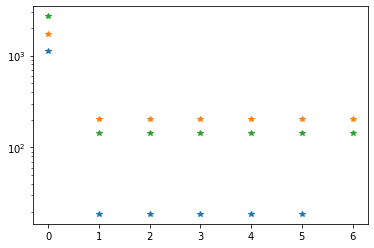

In [289]:
import matplotlib.pyplot as plt
%matplotlib inline
for idx in range(len(norms)):
    plt.semilogy(norms[idx],'*')

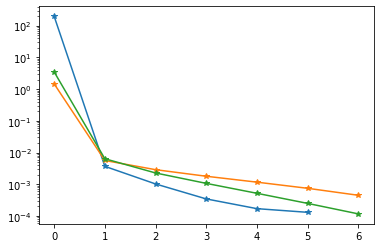

In [290]:
for idx in range(len(delta_u_norms)):
    plt.semilogy(delta_u_norms[idx],'-*')

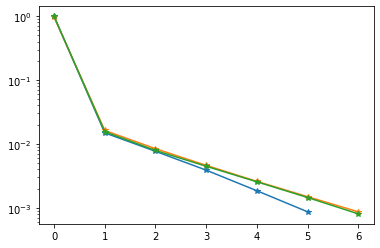

In [291]:
for idx in range(len(delta_u_norms)):
    plt.semilogy(delta_v_norms[idx],'-*')

In [190]:
X

array([[ 0.94933333,  0.        ,  0.242     , ..., -0.38016667,
        -0.13533333,  0.369     ],
       [ 0.27983333,  0.        ,  1.0385    , ...,  0.07616667,
        -0.36633333,  0.0345    ],
       [ 0.74866667,  0.        ,  1.1605    , ...,  0.89633333,
         0.215     , -0.0495    ],
       ...,
       [ 0.69683333,  0.        ,  1.042     , ..., -0.1995    ,
         1.08466667, -0.4065    ],
       [-0.28066667,  0.        ,  0.7175    , ...,  0.37      ,
        -0.1615    , -0.5665    ],
       [-0.3155    ,  0.        ,  0.6455    , ..., -0.13016667,
         0.35083333,  0.1445    ]])

In [191]:
y

array([0, 0, 0, ..., 2, 2, 2])

In [192]:
from sklearn.cluster import KMeans

In [206]:
clstr = KMeans(n_clusters=3)

In [235]:
clstr.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [236]:
val = clstr.predict(X)

In [237]:
y

array([0, 0, 0, ..., 2, 2, 2])

In [238]:
val.shape

(1509,)

In [239]:
y.shape

(1509,)

In [232]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_tr = pca.fit_transform(X)


In [271]:
X_tr.shape

(1509, 2)

In [234]:
val.shape

(12129,)

In [228]:
val.shape

(12129,)

In [229]:
y.shape

(1509,)

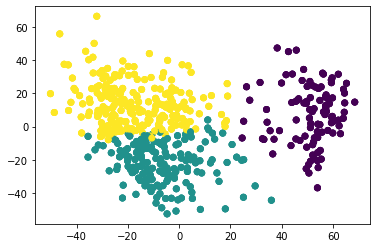

In [240]:
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=val)

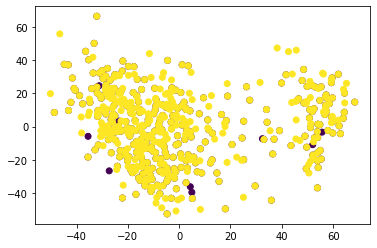

In [270]:
plt.scatter(X_tr[700:1500, 0], X_tr[700:1500, 1], c=y[700:1500])

array([0, 0, 0, ..., 2, 2, 2])